In [17]:
# Setup code for Google Colab
USE_COLAB = True
if USE_COLAB:
    print("Using Colab!")
    %load_ext autoreload
    %autoreload 2

    from google.colab import drive
    drive.mount('/content/drive')

    import os
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS545/SVM-Variations'
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    print(os.listdir(GOOGLE_DRIVE_PATH))

    import sys
    sys.path.append(GOOGLE_DRIVE_PATH)

    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torchvision
    import statistics
    import random
    import time
    import math
    import numpy as np
    import cv2
    import copy
    import shutil
    import os
    import json

    import matplotlib.pyplot as plt
    %matplotlib inline

    !pip3 install -q idx2numpy

    # install qp solver
    !pip3 install -q qpth
    import qpth

    if torch.cuda.is_available:
      print('Good to go!')
    else:
      print('Please set GPU via Edit -> Notebook Settings.')

Using Colab!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['toy_data.mat', '__pycache__', 'kernelSVM_try.ipynb', 'functions.py']
Good to go!


In [9]:
# test qp example (Ans: 0.2500, 0.7500)
Q = 2*torch.tensor([ [2, .5], [.5, 1] ])
p = torch.tensor([1.0, 1.0])
G = torch.tensor([[-1.0,0.0],[0.0,-1.0]])
h = torch.tensor([0.0,0.0])
A = torch.tensor([[1.0, 1.0]])
b = torch.tensor(1.0)
sol = qpth.qp.QPFunction()(Q, p, G, h, A, b)
print(sol)

tensor([[0.2500, 0.7500]])


X: torch.Size([400, 2]) , Y: torch.Size([400]) , on  cpu
t_k =  4.415102243423462
t_qp =  0.2261960506439209
21 support vectors out of 400 points


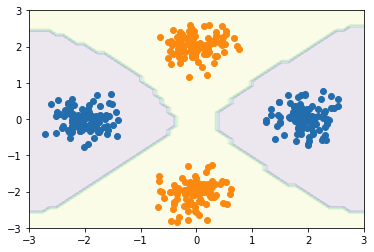

In [18]:
"""
kernel SVM by python:
https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/

QP solver cvxopt:
http://cvxopt.org/install/index.html [install package first!!]
https://cvxopt.org/userguide/coneprog.html#s-qp
https://cvxopt.org/examples/tutorial/qp.html

QP solver qpth:
https://locuslab.github.io/qpth/
"""

import numpy as np
import torch
import time

def linear_kernel(x1, x2):
    """
    x1 and x2 are np.array or torch.tensor with shape (D,) where D is the dimension.
    """
    return np.dot(x1, x2)

def gaussian_kernel(x1, x2, gamma=1):
    """
    x1 and x2 are np.array or torch.tensor with shape (D,) where D is the dimension.
    """
    return torch.exp(-gamma * torch.norm(x1-x2)**2)


class kernelSVM(object):
    def __init__(self, kernel, C=None, eps=1e-3):
        self.kernel = kernel
        if C is not None: # without slack variables
            self.C = float(self.C)
        else: # with slack variables
            self.C = C
        self.alpha = None
        self.sv = None
        self.sv_y = None
        self.b = 0.0
        self.eps = eps
    
    def train(self, X, y):
        """
        Take in the training data and labels and then save alpha, sv, sv_y, and b.
        X: A PyTorch tensor of shape (N, D) containing N data points and each point has dimension D.
        y: A PyTorch tensor of shape (N,) containing labels for the data.
        """
        N, D = X.shape
        yy = np.array(y.cpu(), dtype = np.dtype(float))

        # Create kernel matrix K
        t1 = time.time()
        K = torch.zeros((N, N),  device=X.device)
        for i in range(N):
            for j in range(N):
                if j>i:
                    kk = self.kernel(X[i,:], X[j,:])
                    K[i,j] = kk
                    K[j,i] = kk
                elif j==i:
                    K[i,j] = self.kernel(X[i,:], X[j,:])
        t_k = time.time() - t1
        print("t_k = ", t_k)
        
        # Set up QP problem
        Q = torch.outer(y, y) * K + self.eps*torch.eye(N, device=X.device)
        p = -torch.ones(N, device=X.device)
        A = torch.reshape(y, (1,N)) # reshape as 2D
        b = torch.zeros(1, device=X.device)
        
        if self.C is None:
            G = torch.diag(-torch.ones(N, device=X.device))
            h = torch.zeros(N, device=X.device)
        else:
            G = torch.vstack((torch.diag(-torch.ones(N, device=X.device)), torch.eye(N, device=X.device)))
            h = torch.hstack((torch.zeros(N, device=X.device), torch.ones(N, device=X.device)*self.C/N))
        
        # Solve alpha by QP
        t2 = time.time()
        solution = qpth.qp.QPFunction()(Q, p, G, h, A, b)
        alpha = solution.view(-1) # reshape as 1D
        t_qp = time.time() - t2
        print("t_qp = ", t_qp)
        
        # Save support vectors
        isSV = alpha>1e-5
        idx = torch.arange(alpha.shape[0])[isSV]
        self.alpha = alpha[isSV]
        self.sv = X[isSV]
        self.sv_y = y[isSV]
        print("%d support vectors out of %d points" % (len(self.alpha), N))
        
        # Calculate and save parameter b
        self.b = torch.sum(self.sv_y)
        for r in range(len(self.alpha)):
            self.b -= torch.sum(self.alpha * self.sv_y * K[idx[r], isSV])
        self.b = self.b / len(self.alpha)
    
    def predict(self, X):
        """
        Take in the test data and output a prediction torch.
        Input:
        -X: A PyTorch tensor of shape (N, D) containing N data points and each point has dimension D.
        Return:
        -y_pred: A PyTorch tensor of shape (N,) containing +1/-1 labels for the X
        """
        N, D = X.shape
        y_pred = torch.zeros(N, device=X.device)
        if self.kernel == linear_kernel:
            W = torch.zeros(D, device=X.device)
            for i in range(len(self.alpha)):
                W += self.alpha[i] * self.sv_y[i] * self.sv[i]
            y_pred = torch.sign(torch.dot(X, W) + self.b)
        else:
            for i in range(N):
                s = 0.0
                for alpha, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                    s += alpha * sv_y * self.kernel(X[i,:], sv)
                y_pred[i] = s
            y_pred = torch.sign(y_pred + self.b)
        return y_pred
    
    def plot_classifier(self, plot_range):
        """
        Note: only for D=2 now!!
        Input:
        plot_range = [x_low, x_upper, y_low, y_upper] array like 
        """
        x = np.linspace(plot_range[0], plot_range[1], 50)
        y = np.linspace(plot_range[2], plot_range[3], 50)
        xx, yy = np.meshgrid(x, y)
        X_test = torch.tensor([[x1, x2] for x1, x2 in zip(np.ravel(xx), np.ravel(yy))], device=X.device)
        z_test = self.predict(X_test)
        z = np.reshape(z_test.cpu(), (xx.shape))
        h = plt.contourf(x, y, z, alpha=0.1)
        plt.show()


# Test kernel SVM by toy example
from functions import *
import scipy.io as sio

# if USE_COLAB:
#   X, Y = load_data("toy_example", os.path.join(GOOGLE_DRIVE_PATH, "toy_data.mat"), "gpu")
# else:
  # X, Y = load_data("toy_example0") # two clusters
X, Y = load_data("toy_example", os.path.join(GOOGLE_DRIVE_PATH, "toy_data.mat")) # four clusters
plot_data(X, Y)
# plot_data(X.cpu(), Y.cpu())

# kernel = linear_kernel
kernel = gaussian_kernel
LSVM = kernelSVM(kernel)
LSVM.train(X, Y)
# y_pred = LSVM.predict
# LSVM.plot_classifier([-1, 3, -3, 1])
LSVM.plot_classifier([-3, 3, -3, 3])